In [1]:
# Import libraries
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

In [2]:
# Style and formatting setup
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15,7)

In [3]:
# Load Data
DATA_PATH = Path("../data/processed/cleaned_data.csv")
df= pd.read_csv(DATA_PATH)
df = df.copy()
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,InvoiceMonth,DayOfWeek,Hour
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.40,12,Tuesday,7
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.00,12,Tuesday,7
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.00,12,Tuesday,7
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",27,2009-12-01 07:45:00,2.10,13085,United Kingdom,56.70,12,Tuesday,7
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.00,12,Tuesday,7
...,...,...,...,...,...,...,...,...,...,...,...,...
767364,580501,23284,DOORMAT KEEP CALM AND COME IN,2,2011-12-04 13:00:00,7.50,14546,United Kingdom,15.00,12,Sunday,13
767365,580501,22507,MEMO BOARD RETROSPOT DESIGN,3,2011-12-04 13:00:00,4.95,14546,United Kingdom,14.85,12,Sunday,13
767366,580502,22469,HEART OF WICKER SMALL,3,2011-12-04 13:15:00,1.65,16931,United Kingdom,4.95,12,Sunday,13
767367,580502,23489,VINTAGE BELLS GARLAND,2,2011-12-04 13:15:00,2.89,16931,United Kingdom,5.78,12,Sunday,13


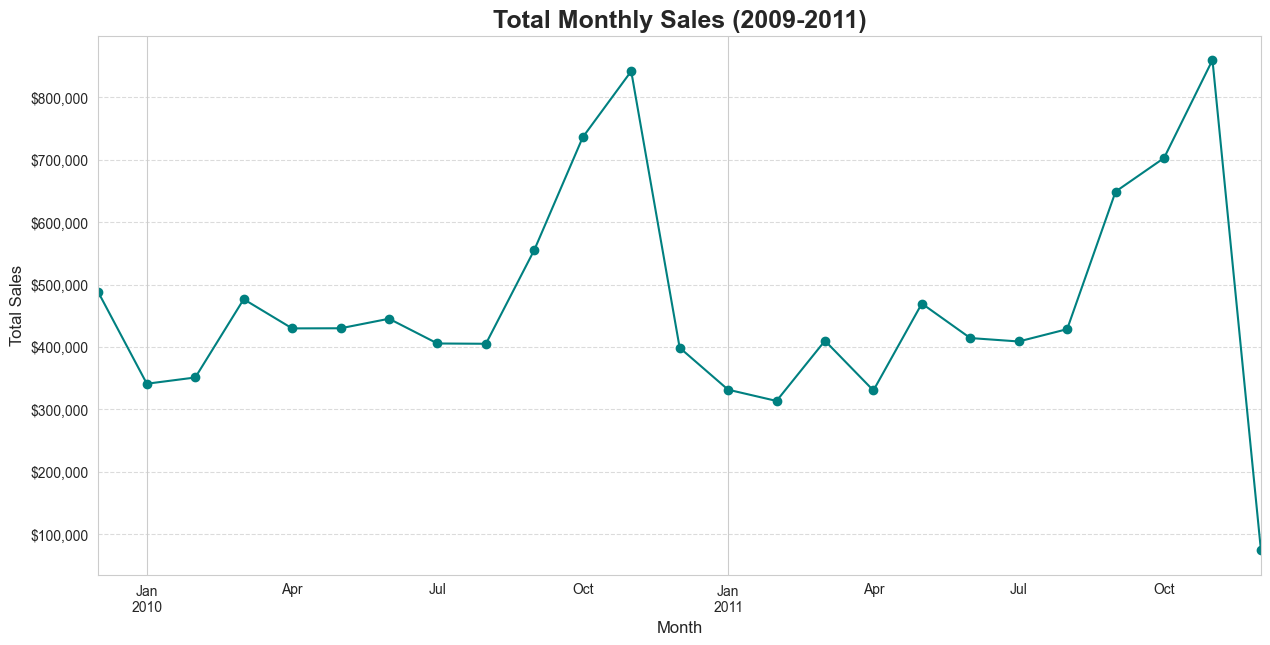

In [4]:
# Anayzing Overall Sales over Time to visualize overall growth and identify seasonal patterns.
# Resample the data by month ('M') and sum the totalprice to get monthly sales
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
monthly_sales = df.set_index('InvoiceDate')['TotalPrice'].resample('ME').sum()

# Line plot
ax = monthly_sales.plot(kind='line', marker='o', color='teal')

#Formatting
ax.set_title('Total Monthly Sales (2009-2011)', fontsize=18, fontweight='bold')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Total Sales', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

#Format y-axis ticks as currenct for readability
from matplotlib.ticker import FuncFormatter
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${y:,.0f}'))


plt.show()

#### Inference
1. Strong Holiday Seasonality: There is a clear and repeating seasonal trend. Sales begin to ramp up in September, peaking dramatically in October and November of both years. This indicates that the business high season in the run-up to the holidays.
2. The "Wholesale" Footprint: The most insightful pattern is the sharp drop in sales during December. A typical B2C (bussiness-to-consumer) retailer would see December as their peak month. The fact that sales peak in November and fall in December strongly suggests a B2B (business-to-business) model. The company's clients who are likely other reatilers stock up before the holiday rush. By December, they have already made their bulk purchases.

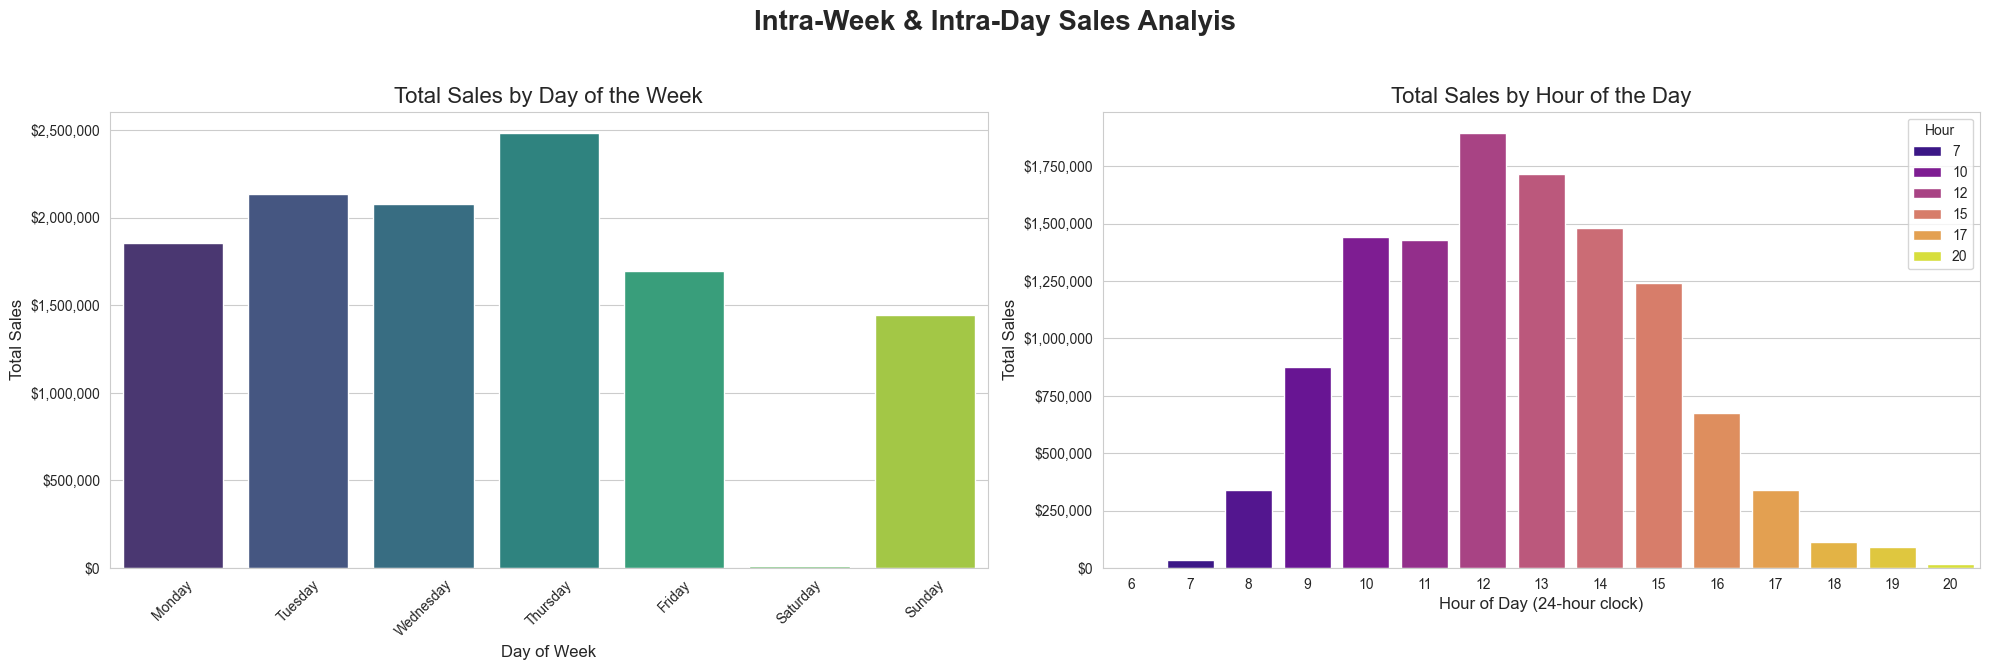

In [5]:
# Sales by Day of Week and Hour
fig, axes = plt.subplots(1,2, figsize=(20,7))
fig.suptitle('Intra-Week & Intra-Day Sales Analyis', fontsize=20, fontweight='bold')

# Sales by Day of week
day_of_week_sales = df.groupby('DayOfWeek')['TotalPrice'].sum().sort_index()

#Correct ordering for days of week
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_of_week_sales = day_of_week_sales.reindex(day_order)

#Barplot
sns.barplot(x=day_of_week_sales.index, y=day_of_week_sales.values,hue= day_of_week_sales.index, ax=axes[0], palette="viridis")
axes[0].set_title('Total Sales by Day of the Week', fontsize=16)
axes[0].set_xlabel('Day of Week', fontsize=12)
axes[0].set_ylabel('Total Sales', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${y:,.0f}'))

# Sales by Hour of the Day
# Group data by Hour and sum TotalPrice
hourly_sales = df.groupby('Hour')['TotalPrice'].sum()

# Bar plot
sns.barplot(x=hourly_sales.index, y=hourly_sales.values, ax=axes[1],hue=hourly_sales.index, palette="plasma")
axes[1].set_title('Total Sales by Hour of the Day', fontsize=16)
axes[1].set_xlabel('Hour of Day (24-hour clock)', fontsize=12)
axes[1].set_ylabel('Total Sales', fontsize=12)
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${y:,.0f}'))


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Inference
The purchasing pattern strongly reinforce hpothesis that this is a B2B(business-to-business) wholesale operation.

1. No Weekend Rush: Unlike a typical consumer retail business, sales are extremly low on Saturday. The bulk of transactions occurs on standard business days (Monday-Friday), with Thursday being the peak day for placing orders.
2. Standard Business Hours: Sales activity mirrors a typical 9-to-5 workday. It begins around 7 am , hits its peak between 10 AM and 2PM, and then gradually declines, dropping off sharply after 5PM.

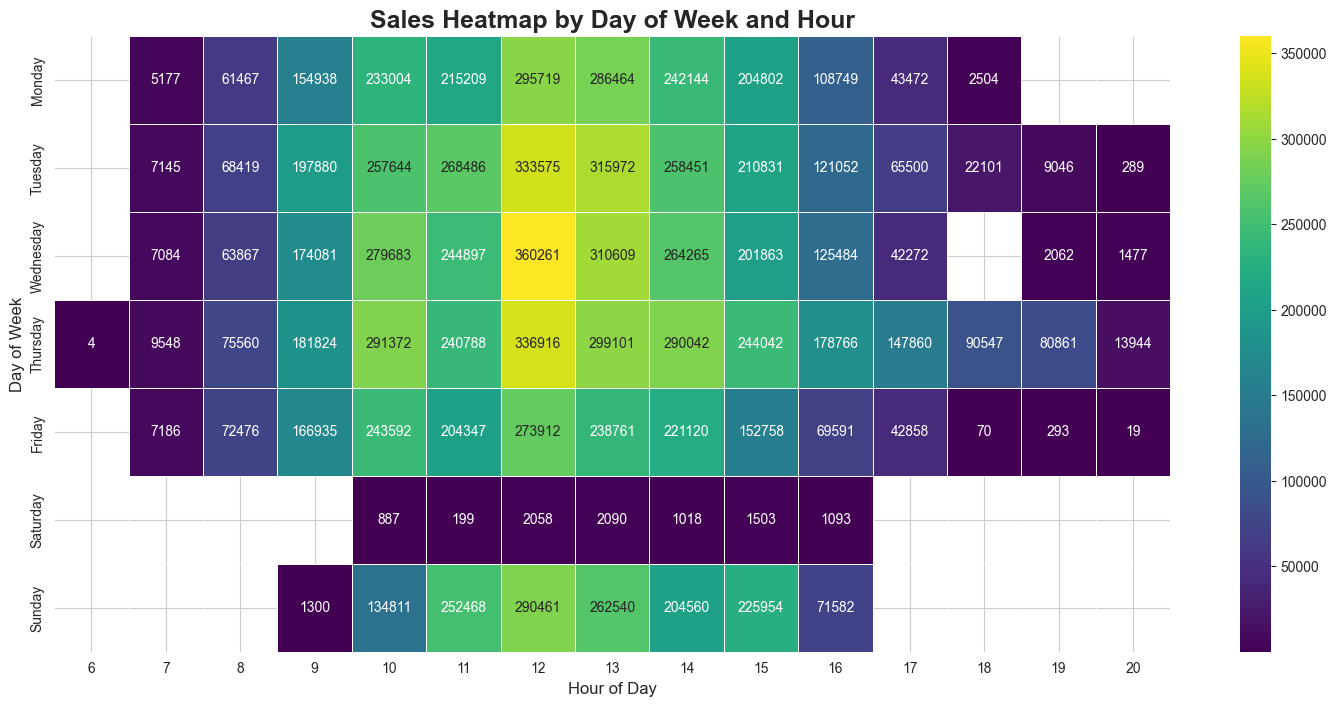

In [6]:
#Sales Heatmap by Day of Week and Hour

# Pivot table to structure the data for the heatmap (sum of TotalPrice for each combination of DayOfWeek and Hour)
heatmap_data = df.pivot_table(
    index='DayOfWeek', 
    columns='Hour', 
    values='TotalPrice', 
    aggfunc='sum'
)

#Change ordering of days
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
heatmap_data = heatmap_data.reindex(day_order)

# Heatmap visualization
plt.figure(figsize=(18, 8))
sns.heatmap(
    heatmap_data, 
    cmap="viridis", 
    annot=True,      
    fmt=".0f",       
    linewidths=.5
)

plt.title('Sales Heatmap by Day of Week and Hour', fontsize=18, fontweight='bold')
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Day of Week', fontsize=12)
plt.show()

#### Inference
This heatmap provides definitive visual evidence that conforms our B2B (business-to-business) model hypothesis.
<br><n>
The commercial "hotspot" for the business is clearly concentrated between 10 AM and 3PM on weekdays, with a peak around noon on Thursdays. The activity on Saturday is neglible, Sunday is significantly lower than any weekday.

This further confirms this is not a pattern of individual consumers shoffping after work or on weekends. This is the pattern of other business placing their stock orders during theier own standard operating hours. This insight is crucial for timing B2B marketing campaigns, scheduling sales calls, and planning server maintenance for off-peak times like evenings or Saturdays.

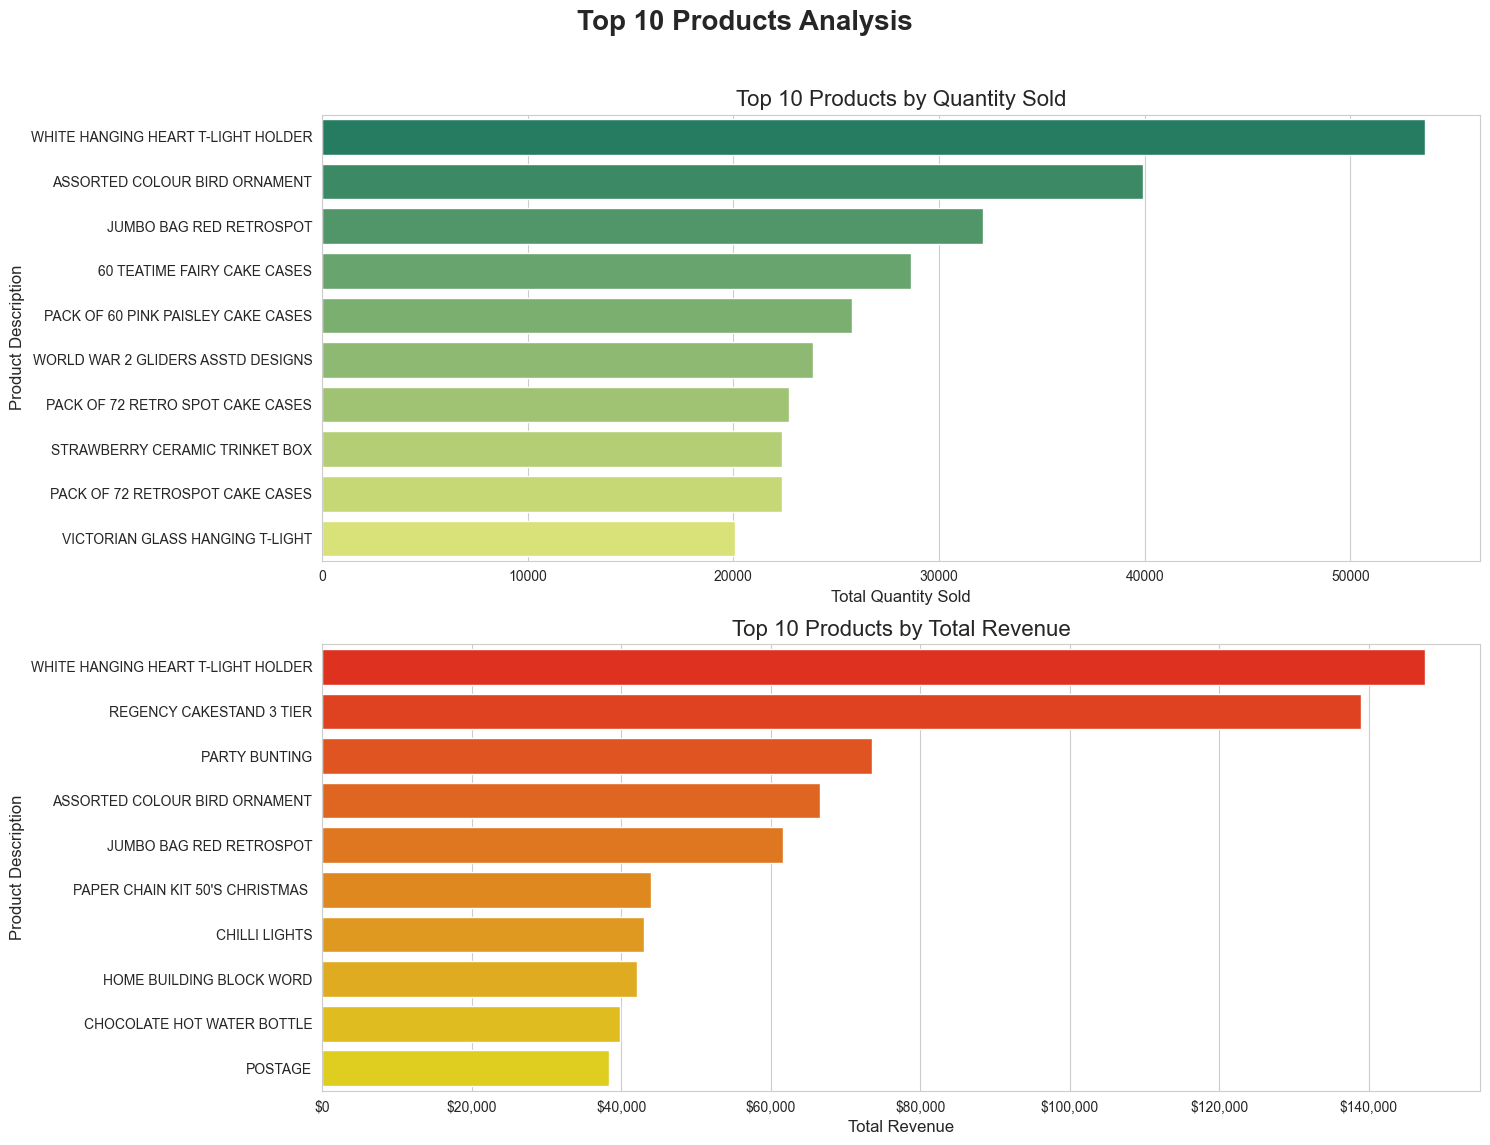

In [7]:
# Top Products Analysis
fig, axes = plt.subplots(2, 1, figsize=(15, 12))
fig.suptitle('Top 10 Products Analysis', fontsize=20, fontweight='bold')

# Top 10 Products by Quantity Sold
top_10_quantity = df.groupby('Description')['Quantity'].sum().nlargest(10)

sns.barplot(x=top_10_quantity.values, y=top_10_quantity.index, ax=axes[0], palette="summer", hue=top_10_quantity.index, legend=False)
axes[0].set_title('Top 10 Products by Quantity Sold', fontsize=16)
axes[0].set_xlabel('Total Quantity Sold', fontsize=12)
axes[0].set_ylabel('Product Description', fontsize=12)


#Top 10 Products by Total Revenue
top_10_revenue = df.groupby('Description')['TotalPrice'].sum().nlargest(10)

sns.barplot(x=top_10_revenue.values, y=top_10_revenue.index, ax=axes[1], palette="autumn", hue=top_10_revenue.index, legend=False)
axes[1].set_title('Top 10 Products by Total Revenue', fontsize=16)
axes[1].set_xlabel('Total Revenue', fontsize=12)
axes[1].set_ylabel('Product Description', fontsize=12)
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:,.0f}'))


plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

In [8]:
df['Description'].value_counts().head(50)

Description
WHITE HANGING HEART T-LIGHT HOLDER    4982
REGENCY CAKESTAND 3 TIER              3302
ASSORTED COLOUR BIRD ORNAMENT         2666
JUMBO BAG RED RETROSPOT               2611
PARTY BUNTING                         2087
LUNCH BAG  BLACK SKULL.               2023
REX CASH+CARRY JUMBO SHOPPER          1923
LUNCH BAG SPACEBOY DESIGN             1873
STRAWBERRY CERAMIC TRINKET BOX        1859
HOME BUILDING BLOCK WORD              1844
LUNCH BAG CARS BLUE                   1809
HEART OF WICKER SMALL                 1804
60 TEATIME FAIRY CAKE CASES           1801
WOODEN FRAME ANTIQUE WHITE            1776
HEART OF WICKER LARGE                 1769
POSTAGE                               1765
BAKING SET 9 PIECE RETROSPOT          1729
JUMBO STORAGE BAG SUKI                1711
JUMBO SHOPPER VINTAGE RED PAISLEY     1672
PAPER CHAIN KIT 50'S CHRISTMAS        1670
WOODEN PICTURE FRAME WHITE FINISH     1660
RED HANGING HEART T-LIGHT HOLDER      1636
NATURAL SLATE HEART CHALKBOARD        1629

#### Inference
Products that sell in the highest quantities are not necessarily that ones that generate the most revenue.
1. High-Volume Drivers: The top-selling items by quantity are small, likely low-cost goods such as "WHITE HANGING HEART T-LIGHT HOLDER," various cake cases, and small ornaments. These are the "bread and butter" items that keep inventory moving.
2. High-Value Drivers: The top items by revenue are a mix. Some high-volume items make the list, but it's led by higher-priced products like the "REGENCY CAKESTAND 3 TIER." This shows that while the business sells a lot of small items, its significant revenue comes from these more expensive "centerpiece" products.
3. Critical Data Anomaly: The most important finding is the presence of "POSTAGE" in the top revenue list. This is not product; This is operational charge that have been recorded as sales. For any product-specific analysis, it must be filtered out.

In [9]:
#filter out the non-product code
display(df['Description'].value_counts().sum())
non_product_items = ['POSTAGE']
df = df[~df['Description'].isin(non_product_items)].copy()
display(df['Description'].value_counts().sum())

np.int64(767369)

np.int64(765604)

In [10]:
# Product Quadrant Analysis
#Aggregate Data at the Product Level
# Group by product description and aggregate the key metrics
product_summary = df.groupby('Description').agg(
    TotalQuantity=('Quantity', 'sum'),
    TotalRevenue=('TotalPrice', 'sum')
).reset_index()

print("Product Summary DataFrame")
print(f"Created a summary for {len(product_summary)} unique products.")
display(product_summary.head())

Product Summary DataFrame
Created a summary for 5280 unique products.


,Description,TotalQuantity,TotalRevenue
0,DOORMAT UNION JACK GUNS AND ROSES,167,1071.25
1,3 STRIPEY MICE FELTCRAFT,583,1110.75
2,4 PURPLE FLOCK DINNER CANDLES,239,425.85
3,50'S CHRISTMAS GIFT BAG LARGE,1413,1760.58
4,ANIMAL STICKERS,301,63.21


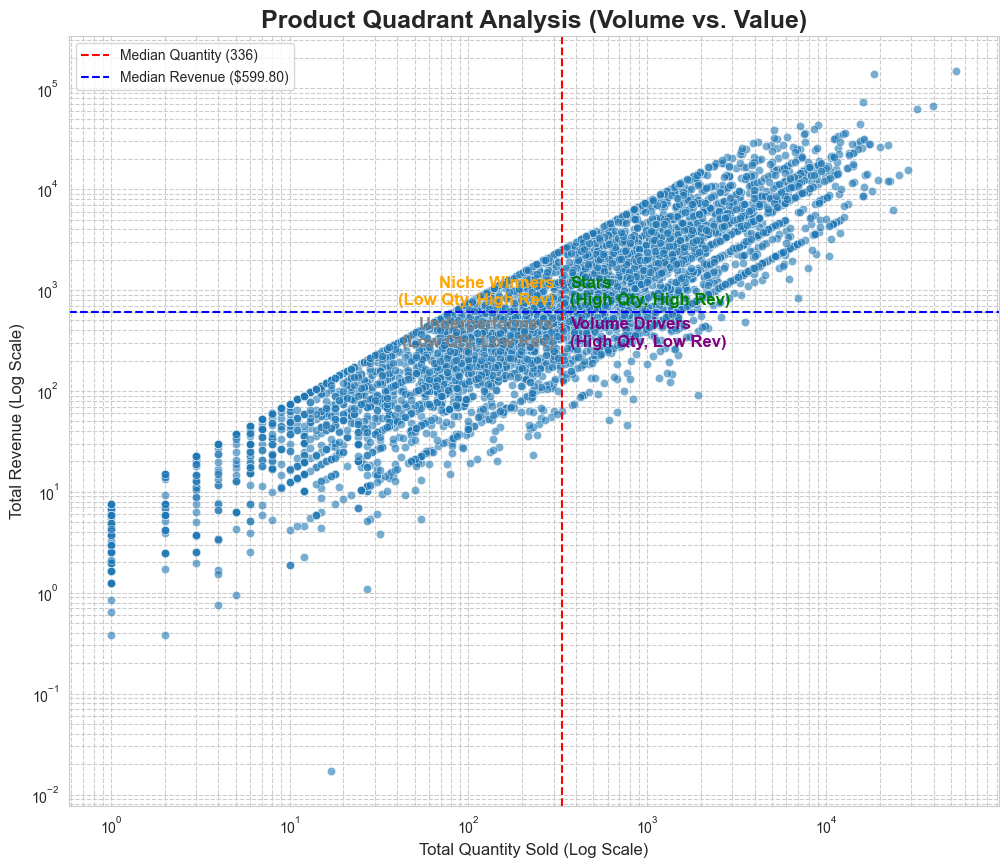

In [11]:
#Product Quadrant Scatter Plot

# Median values for quadrant lines
median_qty = product_summary['TotalQuantity'].median()
median_rev = product_summary['TotalRevenue'].median()

# Create the scatter plot
plt.figure(figsize=(12, 10))
ax = sns.scatterplot(
    data=product_summary, 
    x='TotalQuantity', 
    y='TotalRevenue',
    alpha=0.6,
    edgecolor="w"
)

# Axes set to a logarithmic scale to better visualize the wide range of values
ax.set_xscale('log')
ax.set_yscale('log')

# Quadrant lines
ax.axvline(median_qty, color='red', linestyle='--', label=f'Median Quantity ({median_qty:.0f})')
ax.axhline(median_rev, color='blue', linestyle='--', label=f'Median Revenue (${median_rev:.2f})')

# Text to label the quadrants
plt.text(median_qty * 1.1, median_rev * 1.1, "Stars\n(High Qty, High Rev)", 
         ha='left', va='bottom', fontsize=12, fontweight='bold', color='green')
plt.text(median_qty * 0.9, median_rev * 1.1, "Niche Winners\n(Low Qty, High Rev)", 
         ha='right', va='bottom', fontsize=12, fontweight='bold', color='orange')
plt.text(median_qty * 1.1, median_rev * 0.9, "Volume Drivers\n(High Qty, Low Rev)", 
         ha='left', va='top', fontsize=12, fontweight='bold', color='purple')
plt.text(median_qty * 0.9, median_rev * 0.9, "Underperformers\n(Low Qty, Low Rev)", 
         ha='right', va='top', fontsize=12, fontweight='bold', color='grey')

# Formatting
ax.set_title('Product Quadrant Analysis (Volume vs. Value)', fontsize=18, fontweight='bold')
ax.set_xlabel('Total Quantity Sold (Log Scale)', fontsize=12)
ax.set_ylabel('Total Revenue (Log Scale)', fontsize=12)
ax.legend()
plt.grid(True, which="both", ls="--")
plt.show()

#### Inference<br> 

1. Stars (High Volume, High Revenue): These are core products. The strategy here is to protect, promote, and ensure they are always in stock.

2. Niche Winners (Low Volume, High Revenue): These are likely high-margin or specialty items. The strategy is to market them to the right customer segments and ensure pricing is optimized.

3. Volume Drivers (High Volume, Low Revenue): These are "bread and butter" or "acquisition" products. The strategy is to use them in promotions to attract new customers who may then discover "Star" products.

4. Underperformers (Low Volume, Low Revenue): This is the "long tail." The strategy for this group is to evaluate their profitability and consider delisting items that are not contributing to customer acquisition or the bottom line.

 Pareto Analysis Results
Total unique products: 5280
Number of products accounting for 80% of revenue: 1212
Percentage of products accounting for 80% of revenue: 22.95%


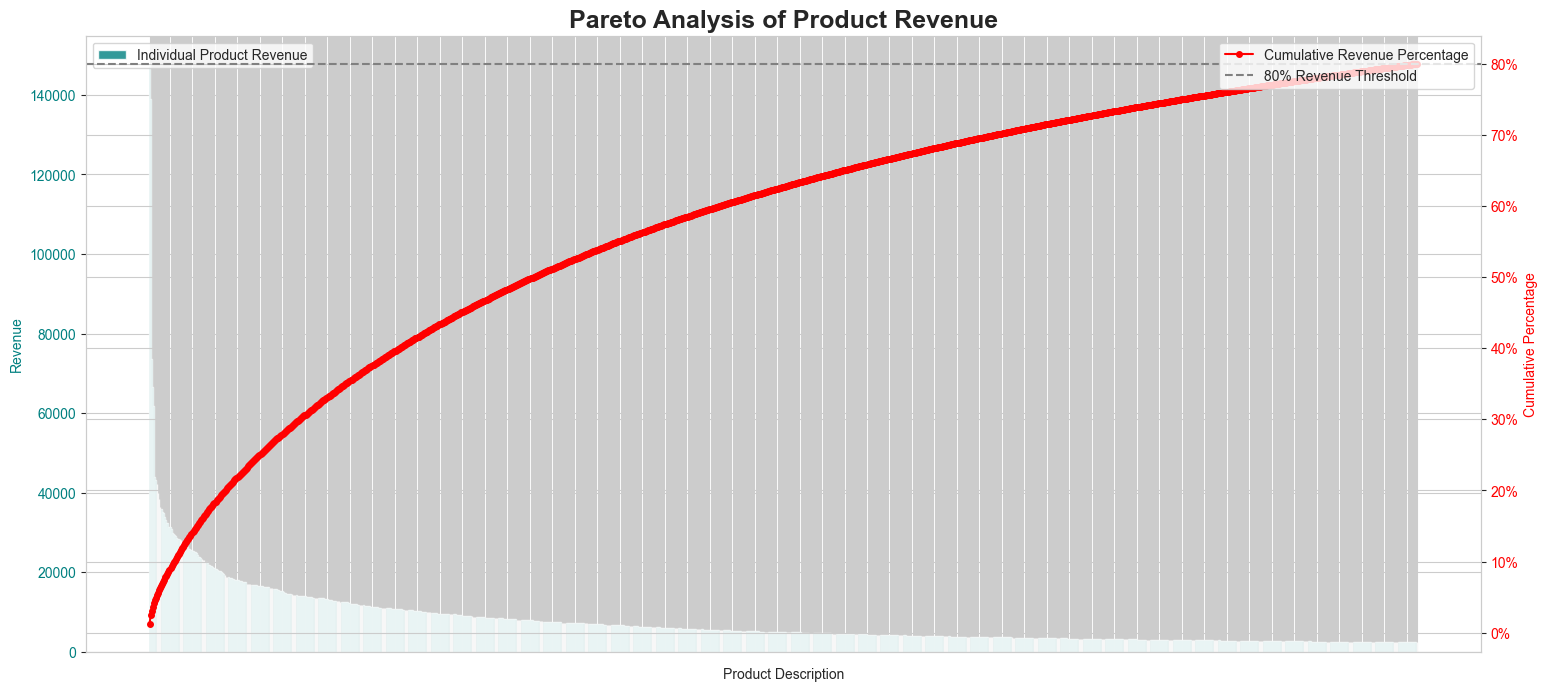

In [12]:
#Pareto Analysis of Products

# Revenue per product and sort
product_revenue = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False)
product_revenue_df = pd.DataFrame({'Revenue': product_revenue})

# Cumulative percentage
product_revenue_df['Cumulative_Revenue'] = product_revenue_df['Revenue'].cumsum()
product_revenue_df['Cumulative_Percentage'] = product_revenue_df['Cumulative_Revenue'] / product_revenue_df['Revenue'].sum() * 100

# Identify the "vital few" products
vital_few_count = product_revenue_df[product_revenue_df['Cumulative_Percentage'] <= 80].shape[0]
total_products = len(product_revenue_df)
vital_few_percentage = (vital_few_count / total_products) * 100

print(" Pareto Analysis Results")
print(f"Total unique products: {total_products}")
print(f"Number of products accounting for 80% of revenue: {vital_few_count}")
print(f"Percentage of products accounting for 80% of revenue: {vital_few_percentage:.2f}%")

# Pareto Chart
fig, ax1 = plt.subplots(figsize=(18, 8))
ax1.bar(product_revenue_df.index[:vital_few_count], product_revenue_df['Revenue'][:vital_few_count], color='teal', alpha=0.8, label='Individual Product Revenue')
ax1.set_xlabel('Product Description')
ax1.set_ylabel('Revenue', color='teal')
ax1.tick_params(axis='y', labelcolor='teal')
ax1.set_xticklabels([]) # Hide x-axis labels for readability

# Second y-axis for the cumulative percentage
ax2 = ax1.twinx()
ax2.plot(product_revenue_df.index[:vital_few_count], product_revenue_df['Cumulative_Percentage'][:vital_few_count], color='red', marker='o', ms=4, label='Cumulative Revenue Percentage')
ax2.set_ylabel('Cumulative Percentage', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.yaxis.set_major_formatter(PercentFormatter())

# 80% line
ax2.axhline(80, color='grey', linestyle='--', label='80% Revenue Threshold')

plt.title('Pareto Analysis of Product Revenue', fontsize=18, fontweight='bold')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

#### Inference
The analysis confirms a classic Pareto Principle (or 80/20) rule in product catalog. Results shows that 23% of unique products are responsible for 80% of the total sales revenue.<br>

This is a critical finding. It means that the business is heavily reliant on a relatively small core of "vital few" products for its financial success. The remaining 77% of the products, the "trivial many," contribute only 20% of the revenue.

##### Strategic Implications:
* Protect Core: The top 23% of product are most valuable assests. These items must be managed carefully, ensuring they are always in stock, featured prominently, and potentially bundled with other items to increase order value.
* Analyze the Long Trail: The business needs to evaluate the profitability of the other 77% of products. Are they important for attracting new customers, or are they incurring inventory costs without providing significant returns? This could lead to strategic decisions about delisting underperforming items.
  

In [13]:
# Profile the Vital Few vs. Trivial Many

# Re-create the Pareto data to identify two groups
product_revenue = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False)
product_revenue_df = pd.DataFrame({'Revenue': product_revenue})
product_revenue_df['Cumulative_Revenue'] = product_revenue_df['Revenue'].cumsum()
product_revenue_df['Cumulative_Percentage'] = product_revenue_df['Cumulative_Revenue'] / product_revenue_df['Revenue'].sum() * 100

# Product descriptions for each group
vital_few_products = product_revenue_df[product_revenue_df['Cumulative_Percentage'] <= 80].index
trivial_many_products = product_revenue_df[product_revenue_df['Cumulative_Percentage'] > 80].index

# Filter main DataFrame into two new DataFrames
df_vital_few = df[df['Description'].isin(vital_few_products)]
df_trivial_many = df[df['Description'].isin(trivial_many_products)]

print(f"Identified {len(vital_few_products)} 'Vital Few' and {len(trivial_many_products)} 'Trivial Many' products.")

#Calculate and compare key metrics for each group
vital_stats = {
    "Group": "Vital Few",
    "Total Revenue": df_vital_few['TotalPrice'].sum(),
    "Number of Products": len(vital_few_products),
    "Avg Price per Item": df_vital_few['Price'].mean(),
    "Avg Quantity per Transaction": df_vital_few['Quantity'].mean(),
    "Unique Customers Reached": df_vital_few['Customer ID'].nunique()
}

trivial_stats = {
    "Group": "Trivial Many",
    "Total Revenue": df_trivial_many['TotalPrice'].sum(),
    "Number of Products": len(trivial_many_products),
    "Avg Price per Item": df_trivial_many['Price'].mean(),
    "Avg Quantity per Transaction": df_trivial_many['Quantity'].mean(),
    "Unique Customers Reached": df_trivial_many['Customer ID'].nunique()
}

# Summary DataFrame
summary_df = pd.DataFrame([vital_stats, trivial_stats]).set_index('Group')

print("\n Comparative Profile of Product Groups")
display(summary_df)

Identified 1212 'Vital Few' and 4068 'Trivial Many' products.

 Comparative Profile of Product Groups


,Total Revenue,Number of Products,Avg Price per Item,Avg Quantity per Transaction,Unique Customers Reached
Group,,,,,
Vital Few,9323869.530,1212,2.902361,8.168773,5778
Trivial Many,2333319.208,4068,2.028618,8.617676,5491


#### Inference<br> 
The data confirms that "Vital Few" and "Trivial Many" product groups play two distinct and crucial roles for the business:

1. The "Vital Few" are Core Value Drivers: This group consists of higher-priced items (Avg Price $2.90) that are the primary engines of revenue. They are the core of business's profitability.

2. The "Trivial Many" are Acquisition Engine: This is the most critical insight. Despite contributing less to revenue, these lower-priced items (Avg Price $2.02) are purchased by a massive number of unique customers (5,491, nearly as many as the vital few). This strongly suggests these products function as "discovery items" or "acquisition products." Customers are likely drawn into your ecosystem by these items, and their first purchase is often from this long-tail catalog.

##### Conclusion:<br>
The "Trivial Many" are not trivial at all; they are the gateway to business. While the "Vital Few" make you the most money, the "Trivial Many" are essential for attracting the broad customer base that eventually discovers and purchases your high-value items.

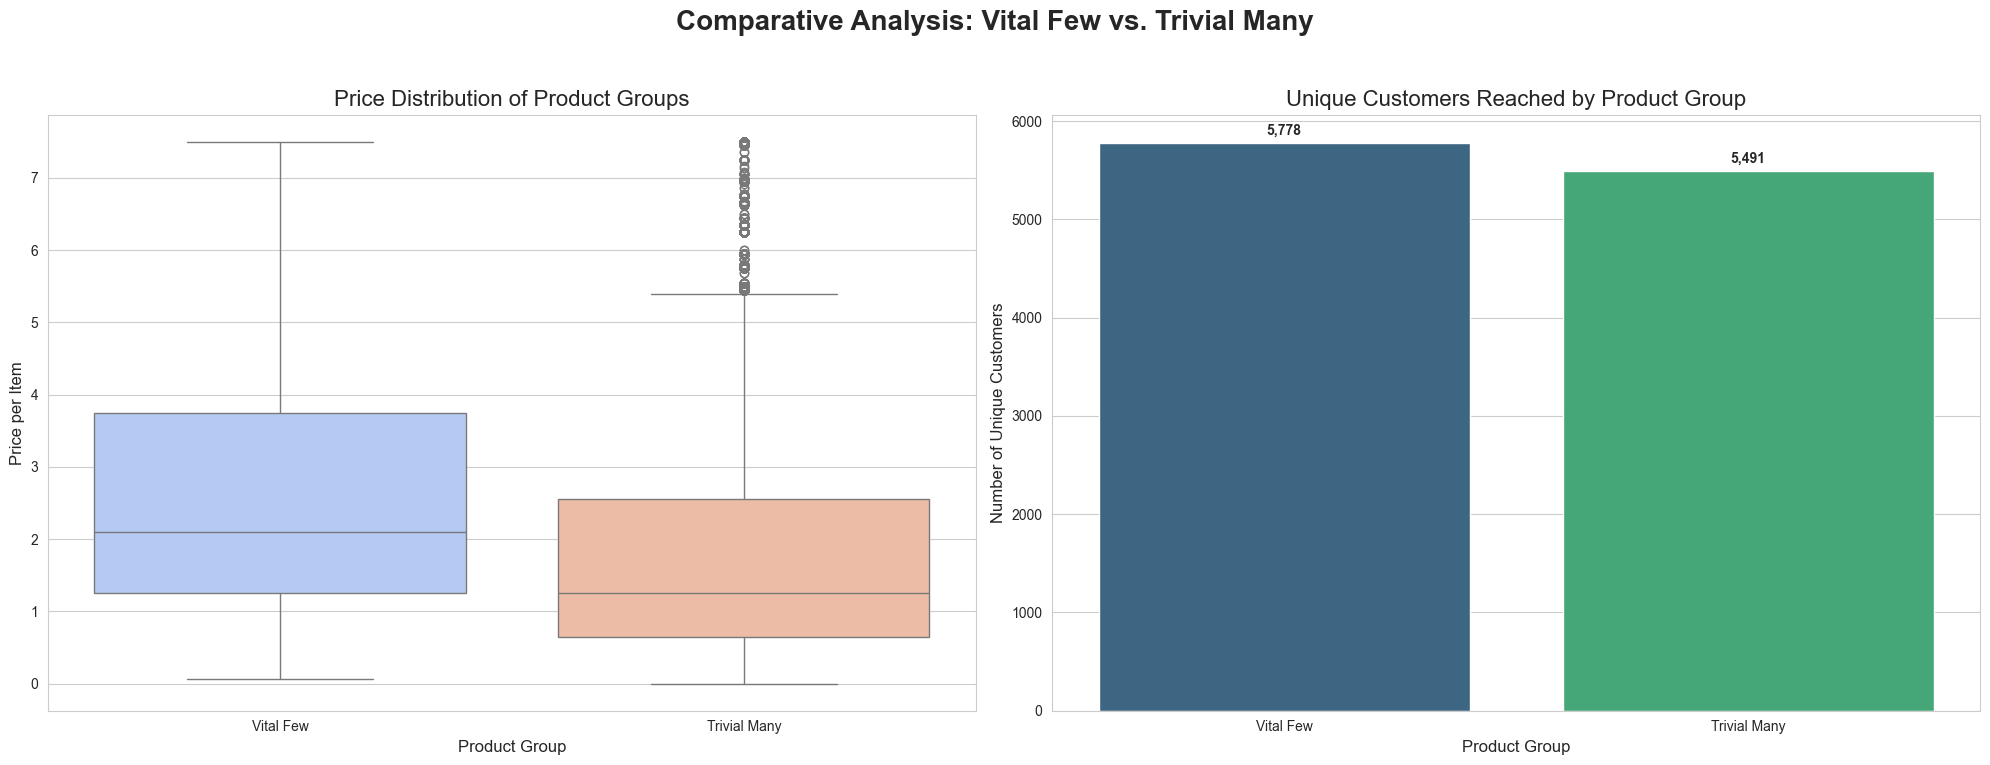

In [14]:
# Two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Comparative Analysis: Vital Few vs. Trivial Many', fontsize=20, fontweight='bold')

# Plot 1: Price Distribution Comparison
price_data = pd.concat([
    df_vital_few[['Price']].assign(Group='Vital Few'),
    df_trivial_many[['Price']].assign(Group='Trivial Many')
])

sns.boxplot(x='Group', y='Price', hue='Group', data=price_data, ax=axes[0], palette="coolwarm", legend=False)
axes[0].set_title('Price Distribution of Product Groups', fontsize=16)
axes[0].set_xlabel('Product Group', fontsize=12)
axes[0].set_ylabel('Price per Item', fontsize=12)

# Plot 2: Customer Reach Comparison
summary_df_reset = summary_df.reset_index().rename(columns={'index': 'Group', 'Unique Customers Reached': 'Customers'})
sns.barplot(data=summary_df_reset, x='Group', y='Customers', hue='Group', palette='viridis', ax=axes[1], legend=False)
axes[1].set_title('Unique Customers Reached by Product Group', fontsize=16)
axes[1].set_xlabel('Product Group', fontsize=12)
axes[1].set_ylabel('Number of Unique Customers', fontsize=12)

# Data labels
for p in axes[1].patches:
    height = p.get_height()
    axes[1].annotate(f"{height:,.0f}", 
                     (p.get_x() + p.get_width() / 2., height), 
                     ha='center', va='center', 
                     xytext=(0, 9), 
                     textcoords='offset points',
                     fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

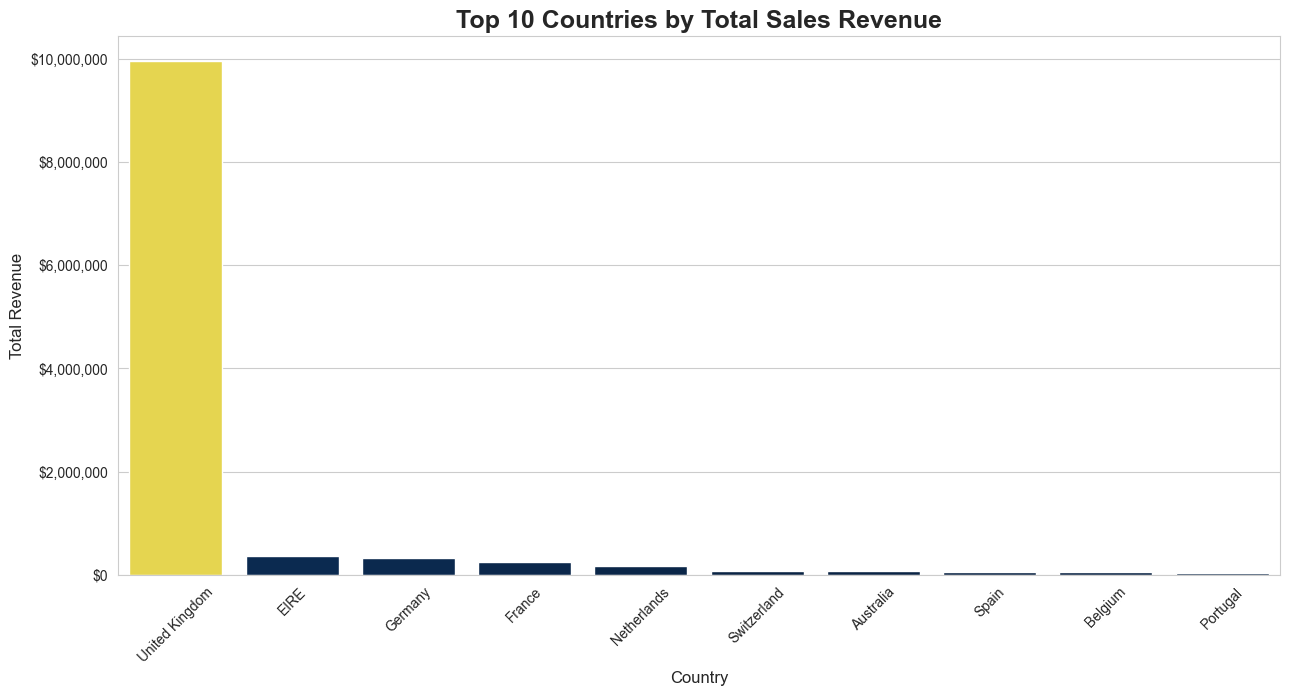

In [15]:
# Geographical Sales Analysis
# Group by country and sum the total price
country_sales = df.groupby('Country')['TotalPrice'].sum().nlargest(10)

# Create the bar plot
plt.figure(figsize=(15, 7))
ax = sns.barplot(x=country_sales.index, y=country_sales.values, palette="cividis", hue=country_sales.values, legend=False)

# Formatting
ax.set_title('Top 10 Countries by Total Sales Revenue', fontsize=18, fontweight='bold')
ax.set_xlabel('Country', fontsize=12)
ax.set_ylabel('Total Revenue', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${y:,.0f}'))

plt.show()

#### Inference
This visualization starkly illustrates the immense dominance of the United Kingdom market, which is more than 20 times larger than the next-highest country, EIRE. While the business has a presence in several other strong European economies, its financial performance is fundamentally tied to the UK.

Any meaningful analysis must treat the UK as a separate entity from the "Rest of World" to derive accurate insights and avoid having the UK's behavior mask the patterns of all other customers.

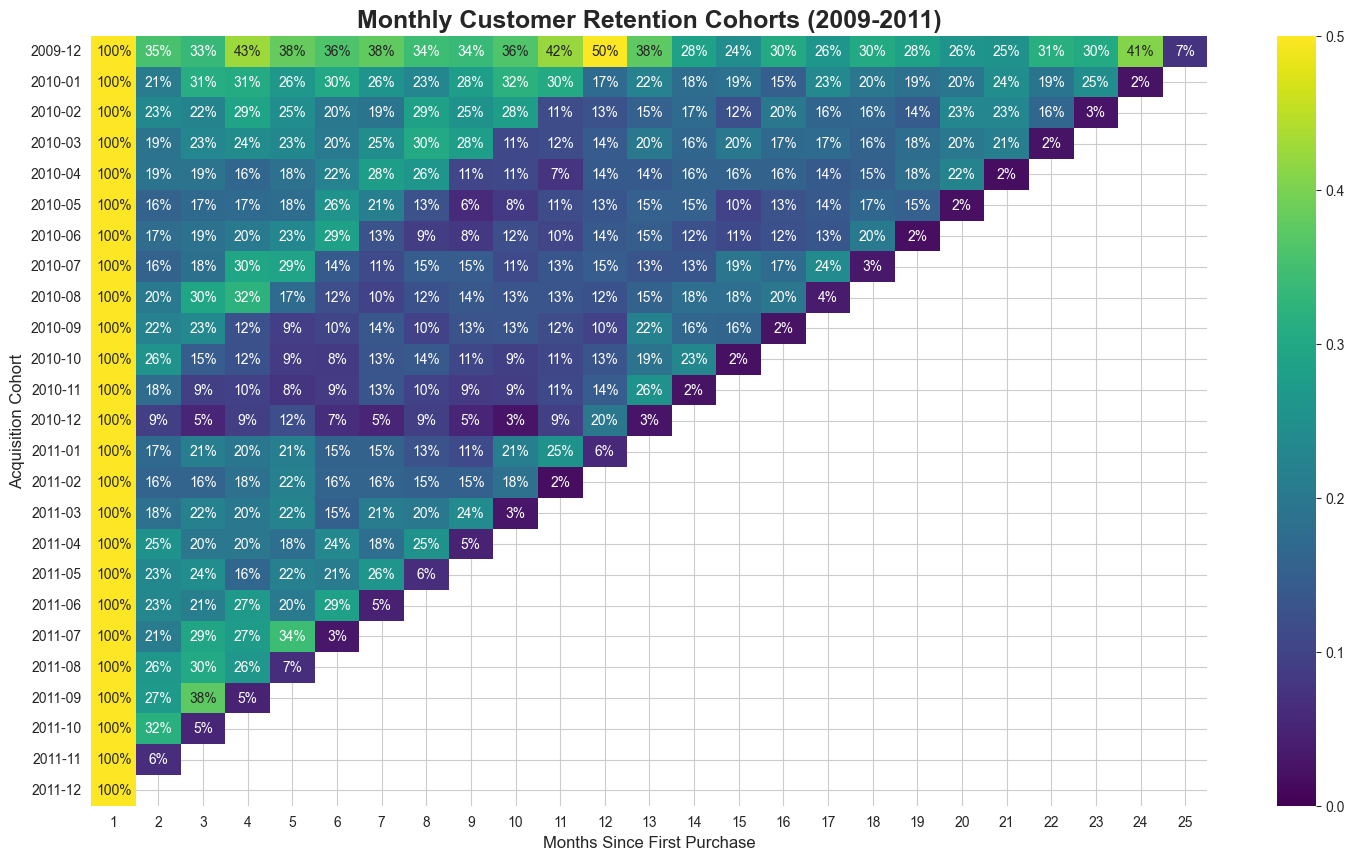

In [16]:
# customer retention cohort analysis

# Function to get the month of a datetime object

def get_month(x):
    return pd.to_datetime(x).to_period('M')

# Set the InvoiceMonth for each transaction
df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)

#Create a 'CohortMonth' column by finding the first purchase month for each customer
df['CohortMonth'] = df.groupby('Customer ID')['InvoiceMonth'].transform('min')

# Function to get the integer offset between two month periods
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year, month

# Integer values for InvoiceMonth and CohortMonth
invoice_year, invoice_month = get_date_int(df, 'InvoiceMonth')
cohort_year, cohort_month = get_date_int(df, 'CohortMonth')

# Calculate the number of months that have passed since the first purchase
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month
df['CohortIndex'] = years_diff * 12 + months_diff + 1

#Retention Table
# Group by CohortMonth and CohortIndex to count unique customers
cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['Customer ID'].apply(pd.Series.nunique).reset_index()

# Pivot table for the heatmap
cohort_counts = cohort_data.pivot_table(index='CohortMonth', columns='CohortIndex', values='Customer ID')

#Calculate retention as a percentage
cohort_sizes = cohort_counts.iloc[:, 0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.index = retention.index.strftime('%Y-%m') # Format the index for readability

# Heatmap
plt.figure(figsize=(18, 10))
sns.heatmap(retention, annot=True, fmt='.0%', cmap='viridis', vmin=0.0, vmax=0.5)
plt.title('Monthly Customer Retention Cohorts (2009-2011)', fontsize=18, fontweight='bold')
plt.xlabel('Months Since First Purchase', fontsize=12)
plt.ylabel('Acquisition Cohort', fontsize=12)
plt.show()

### Inference
This heatmap reveals a "leaky bucket" retention model with a very strong, loyal core.
1. Initial Drop-Off is Significant: The biggest churn happens immediately after the first month. For every cohort, a large percentage of customers (typically 65-80%) are one-time buyers who do not return the following month. This is the "leak" in the bucket and represents the single biggest opportunity for business growth.
2. A Strong, Loyal Core: Despite the initial drop, the customers who do return tend to be very loyal. The 2009-12 cohort is a standout performer, retaining over 30% of its customers even after two years. This indicates that once a customer is engaged, they are likely to remain with the business long-term.
3. Seasonal Re-engagement: There are noticeable bumps in retention around the 12-month mark for earlier cohorts. This suggests that customers acquired during one holiday season are likely to return for the next year's holiday shopping. This is a critical pattern for targeted marketing.


Conclusion: The business excels at creating long-term loyalty but struggles with converting new customers into repeat purchasers. The primary business challenge is to improve rentention in the first one to three months after acquisition

#### "Are our newer customers more or less loyal than our older ones?"

This analysis will compare the average retention rate of different cohort groups (e.g., customers acquired in the first half of 2010 vs. the second half) to see if customer loyalty is improving, declining, or staying the same over time. This is a critical KPI for understanding the health of the business's customer acquisition and retention efforts.

In [18]:
# Analyze early-stage retention (months 2-6)
retention_period = retention.iloc[:, 1:6]

# Compare performance by year
# Slice directly on the datetime index
cohort_2010 = retention_period.loc['2010-01-01':'2010-12-31']
cohort_2011 = retention_period.loc['2011-01-01':'2011-12-31']

avg_retention_2010 = cohort_2010.mean().mean()
avg_retention_2011 = cohort_2011.mean().mean()

print("Average Early-Stage Retention (Months 2-6) by Year")
print(f"2010 Cohorts: {avg_retention_2010:.2%}")
print(f"2011 Cohorts: {avg_retention_2011:.2%}")

#Compare performance by Quarter for 2010
q1_2010 = retention_period.loc['2010-01-01':'2010-03-31'].mean().mean()
q2_2010 = retention_period.loc['2010-04-01':'2010-06-30'].mean().mean()
q3_2010 = retention_period.loc['2010-07-01':'2010-09-30'].mean().mean()
q4_2010 = retention_period.loc['2010-10-01':'2010-12-31'].mean().mean()

print("\nAverage Early-Stage Retention for 2010 Cohorts by Quarter")
quarters = {'Q1 2010': q1_2010, 'Q2 2010': q2_2010, 'Q3 2010': q3_2010, 'Q4 2010': q4_2010}
for quarter, avg_ret in quarters.items():
    print(f"{quarter}: {avg_ret:.2%}")

Average Early-Stage Retention (Months 2-6) by Year
2010 Cohorts: 17.91%
2011 Cohorts: 20.65%

Average Early-Stage Retention for 2010 Cohorts by Quarter
Q1 2010: 22.92%
Q2 2010: 20.15%
Q3 2010: 18.85%
Q4 2010: 9.47%


#### Inference <br>
This numerical analysis confirms and deepens our understanding of customer loyalty, revealing two key insights:

1. Improving Retention: The business's ability to retain new customers is improving over time. The average early-stage retention for customers acquired in 2011 was significantly higher (20.65%) than for those acquired in 2010 (17.91%). This is a positive sign of a strengthening customer relationship.

2. Seasonal Customer Quality: There is a strong seasonal effect on the quality of customers acquired. The retention rate for customers acquired in Q4 of 2010 (9.47%) is drastically lower than for any other quarter. This confirms: customers acquired during the holiday rush are likely "one-and-done" gift shoppers with much lower loyalty than customers acquired during the rest of the year.

##### Strategic Conclusion:<br>
The business should focus marketing efforts on acquiring new customers during the first three quarters of the year, as they are more likely to become loyal, long-term assets. The Q4 marketing strategy should be different, focusing on maximizing the value of single transactions rather than long-term loyalty.

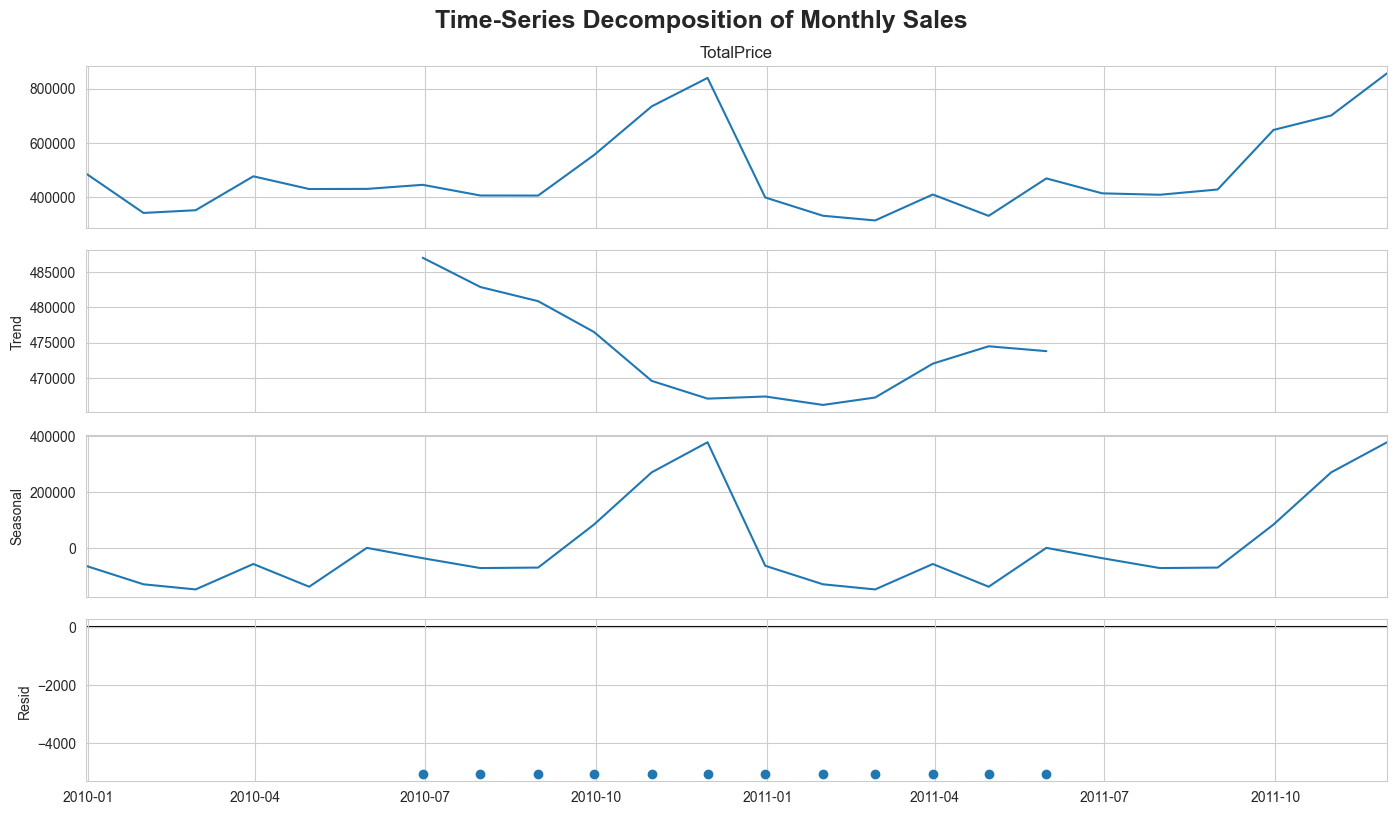

In [18]:
# Time-Series Decomposition
# This allows us to answer crucial questions like, "Is the business actually growing in the long term, or are the sales increases just due to predictable seasonal spikes?"

# The three components are:

# Trend: The underlying long-term direction of sales (growing, declining, or flat).

# Seasonality: The repeating, predictable pattern that occurs each year (e.g., the holiday spike).

# Residuals: The random, unpredictable noise or irregularities left over.

from statsmodels.tsa.seasonal import seasonal_decompose

# Recreate our monthly sales data
monthly_sales = df.set_index('InvoiceDate')['TotalPrice'].resample('ME').sum()

# For a clean decomposition, we should remove the last month (Dec 2011)
# as we know it's an incomplete month of data.
monthly_sales = monthly_sales[:-1]

# Perform the seasonal decomposition
# We specify a period of 12 because we have monthly data with a yearly cycle.
decomposition = seasonal_decompose(monthly_sales, model='additive', period=12)

# Plot the decomposed components
fig = decomposition.plot()
fig.set_size_inches((14, 8))
fig.suptitle('Time-Series Decomposition of Monthly Sales', fontsize=18, fontweight='bold', y=1.02)
plt.show()

#### Inference
1. The Trend is Flat: The most critical insight is from the "Trend" component. After removing the effects of seasonality, the underlying growth trend for the business is relatively flat or even slightly declining through 2010. This suggests that the large sales figures are driven almost entirely by seasonal demand, not by consistent, month-over-month organic growth.

2. Seasonality is Quantified: The "Seasonal" component confirms and quantifies our earlier observations. It shows a predictable annual cycle where sales are lowest in the early months of the year and peak dramatically from September to November.

3. Strategic Implication: The business is highly dependent on its seasonal peak. To achieve true growth, a key strategic goal must be to increase sales and customer engagement during the non-seasonal "off-peak" months (January through August).

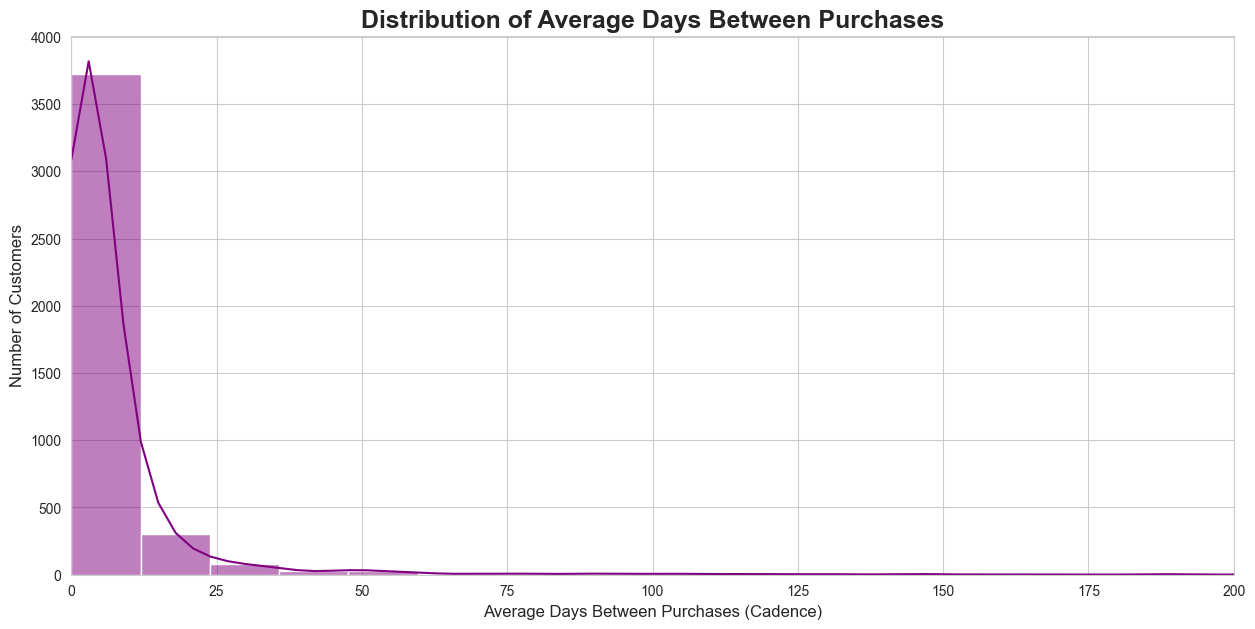

Summary Statistics for Customer Purchase Cadence


count    4212.000000
mean        7.131724
std        20.271005
min         0.000000
25%         1.538993
50%         3.143501
75%         6.534328
max       596.000000
Name: InvoiceDate, dtype: float64

In [19]:
# Customer Purchase Cadence Analysis
# We will analyze the average time between purchases for each customer to uncover different buying "rhythms" and loyalty patterns. This helps us understand if our customer base consists of frequent weekly/monthly shoppers or more sporadic, seasonal buyers.
# We only want to analyze customers who have made repeat purchases
df_repeat_customers = df.groupby('Customer ID').filter(lambda x: x['Invoice'].nunique() > 1)

# Calculate the time difference between consecutive purchases for each customer
# Group by customer, sort by date, and then find the difference between each date
time_between_purchases = df_repeat_customers.groupby('Customer ID')['InvoiceDate'].diff().dt.days

# Calculate the average purchase cadence for each customer
avg_cadence = time_between_purchases.groupby(df_repeat_customers['Customer ID']).mean()

# Visualize the Distribution of Purchase Cadence
plt.figure(figsize=(15, 7))
sns.histplot(avg_cadence, bins=50, kde=True, color='purple')
plt.title('Distribution of Average Days Between Purchases', fontsize=18, fontweight='bold')
plt.xlabel('Average Days Between Purchases (Cadence)', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xlim(0, 200) # Limit the x-axis to focus on the main distribution

plt.show()

# Summary Statistics
print("Summary Statistics for Customer Purchase Cadence")
display(avg_cadence.describe())

Inference<br>
1. The analysis reveals that the business is driven by a highly active core of very frequent purchasers.

2. The most telling statistic is the median of 3.14 days. This means that half of all repeat customers make their next purchase in just over 3 days. Furthermore, 75% of repeat customers return within a week. This is an extremely short and rapid purchasing cycle.

3. This behavior strongly reinforces our B2B hypothesis. This is not the pattern of a consumer making occasional purchases; this is the rhythm of another business restocking its inventory on a near-weekly basis. The long tail (max of 596 days) shows that there are less frequent buyers, but the heart of the business lies with these highly engaged, high-cadence partners.

Strategic Implication: The business must prioritize service and efficiency for this core group. Marketing efforts should be less about one-off "discounts" and more about "partnership" benefits, such as subscription models, easy re-ordering, or bulk-buy incentives that align with this rapid restocking behavior.

In [20]:
# Save preprocessed file
df.to_csv('../data/processed/master_data.csv', index= False)